In [87]:

from poitousprint import get_online_csv, Toflit
from vega import VegaLite
import pandas as pds

toflit_client = Toflit()

origins = get_online_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSKCt7D4NgIN-5UIbwesdTyhhze2dVt0oovodSIu_sdTxGueFJ3EgkpYxh9_gIqXBQ1YjQFYppLxAOo/pub?output=csv')

origin_by_province = {o["origin_norm_ortho"]:o["province"] for o in origins}

origins_LaRochelle = set([o["origin_norm_ortho"] for o in origins if o["province"] in [
        "Aunis", "Poitou", "Angoumois", "Saintonge"]])
origins_LaRochelle_sans_augoumois = set([o["origin_norm_ortho"] for o in origins if o["province"] in [
        "Aunis", "Poitou", "Saintonge"]])

In [2]:

# tous les flux de 89 direction pas la Rochelle et exports
all_flows = toflit_client.get_flows(best_guess_region_prodxpart='1', year='1789', export_import='Exports')

In [ ]:
values_per_direction = {}

for f in all_flows:
    direction = f['customs_region']
    value = f['value'] if f['value'] != '' else 0
    # value = int(value.split('.')[0])
    itype = f['export_import']
    year = f['year']
    if itype == 'Exports':
        if direction not in values_per_direction:
            values_per_direction[direction] = 0
        values_per_direction[direction] += float(value)
# parmi tous les exports des directions quelle est la part qui vient de La Rochelle
def process_flow_against_total_per_region(flow):
    f = flow.copy()
    if f['origin'] != '' and f['origin'] in origins_LaRochelle:
        f['origin_poitou'] = 'De la région de La Rochelle'
    elif f['origin'] == '':
        f['origin_poitou'] = "Pas d'origine"
    else:
        f['origin_poitou'] = 'Hors de la région de La Rochelle'
    f['value'] = float(f['value']) if f['value'] != '' else 0
    f['value_part'] = f['value'] / values_per_direction[f['customs_region']]
    return f
values_per_direction_la_rochelle = 0

for f in all_flows:
    direction = f['customs_region']
    value = f['value'] if f['value'] != '' else 0
    # value = int(value.split('.')[0])
    itype = f['export_import']
    year = f['year']
    if itype == 'Exports' and f['origin'] in origins_LaRochelle:
        values_per_direction_la_rochelle += float(value)
        
def process_flow_rel_region(flow):
    f = flow.copy()
    if f['origin'] != '' and f['origin'] in origins_LaRochelle:
        f['origin_poitou'] = 'De la région de La Rochelle'
    elif f['origin'] == '':
        f['origin_poitou'] = "Pas d'origine"
    else:
        f['origin_poitou'] = 'Hors de la région de La Rochelle'
    f['value'] = float(f['value']) if f['value'] != '' else 0
    f['value_part'] = f['value'] / values_per_direction_la_rochelle
    return f


In [ ]:


VegaLite({
    "title": "Part des échanges de produits de La Rochelle par rapport au total des valeurs des exports par région",
    "mark": "rect",
    "encoding": {
        "x": {
            "type": "nominal", 
            "field": "origin_poitou",
            "title": "origin_poitou"
        },
        "y": {
            "field": "customs_region",
            "type": "nominal",
            "title": "direction des fermes",
            "sort": "-x"
        },
        "color": {
            "type": "quantitative",
            "aggregate": "sum",
            "field": "value_part",
            "title": "Part des échanges de produits de La Rochelle par rapport au total des valeurs des exports par région"
        }
    }
}, pds.DataFrame([process_flow_against_total_per_region(flow) for flow in all_flows]))

In [ ]:


VegaLite({
    "title": "Part des échanges de produits de La Rochelle par rapport au total des produits de La Rochelle",
    "mark": "rect",
    "encoding": {
        "x": {
            "type": "nominal", 
            "field": "origin_poitou",
            "title": "origin_poitou"
        },
        "y": {
            "field": "customs_region",
            "type": "nominal",
            "title": "direction des fermes",
            "sort": "-x"
        },
        "color": {
            "type": "quantitative",
            "aggregate": "sum",
            "field": "value_part",
            "title": "Part des échanges de produits de La Rochelle par rapport au total des produits de La Rochelle"
        }
    }
}, pds.DataFrame([process_flow_rel_region(flow) for flow in all_flows]))

In [ ]:


VegaLite({
    "title": "Part des valeurs des produits originaires de la Rochelle exportés par les autres directions des fermes",
    "mark": "bar",
    "encoding": {
        "y": {
            "type": "nominal", 
            "field": "customs_region",
            "title": "direction des fermes",
            "sort": "-x"
        },
        "x": {
            "type": "quantitative",
            "aggregate": "sum",
            "field": "value_part",
            "title": "Portion des valeurs par rapport au total des exports impliquant des produits de la région"
        }
    }
}, pds.DataFrame([process_flow_rel_region(flow) for flow in all_flows if flow['origin'] in origins_LaRochelle and flow['customs_region'] != 'La Rochelle']))

In [ ]:


VegaLite({
    "title": "Part des exports rapportée au total des produits par région",
    "mark": "circle",
    "encoding": {
        "x": {
            "type": "nominal", 
            "field": "product_revolutionempire",
            "title": "type",
            "sort": "-size"
        },
        "y": {
            "field": "customs_region",
            "type": "nominal",
            "title": "direction des fermes",
            "sort": "-size"
        },
        "color": {
            "field": "origin_poitou",
            "type": "nominal"
        },
        "size": {
            "type": "quantitative",
            "aggregate": "sum",
            "field": "value_part",
            "title": "Part des exports rapportée au total des produits de la région"
        }
    }
}, pds.DataFrame([process_flow_against_total_per_region(flow) for flow in all_flows if process_flow_against_total_per_region(flow)['origin_poitou'] == "De la région de La Rochelle" and flow['customs_region'] != 'La Rochelle']))

In [ ]:



VegaLite({
    "title": "Part des exports de produits originaires de La Rochelle dans les autres directions (relatif au total des produits de la région)",
    "mark": "circle",
    "encoding": {
        "x": {
            "type": "nominal", 
            "field": "product_revolutionempire",
            "title": "type de produit",
            "sort": "-size"
        },
        "y": {
            "field": "customs_region",
            "type": "nominal",
            "title": "direction des fermes",
            "sort": "-size"
        },
        "color": {
            "field": "origin_poitou",
            "type": "nominal"
        },
        "size": {
            "type": "quantitative",
            "aggregate": "sum",
            "field": "value_part",
            "title": "Part des exports par rapport à la valeur totale des produits de la région exportés par la France"
        }
    }
}, pds.DataFrame([process_flow_rel_region(flow) for flow in all_flows if process_flow_rel_region(flow)['origin_poitou'] == "De la région de La Rochelle" and flow['customs_region'] != 'La Rochelle']))

In [ ]:
exports_small_multiples = [process_flow_rel_region(flow) for flow in all_flows if process_flow_rel_region(flow)['origin_poitou'] == "De la région de La Rochelle" and flow['customs_region'] != 'La Rochelle']
exports_small_multiples = sorted(exports_small_multiples, key=lambda f : f["value_part"])
VegaLite({
    "title": "Part des exports de produits originaires de La Rochelle dans les autres directions (petits multiples)",
    "mark": "bar",
    "encoding": {
        "row": {
            "field": "customs_region",
            "type": "nominal",
            "title": "direction des fermes",
            "sort": {
                "op": "sum",
                "field": "value_part",
                "order": "descending"
            }
        },
        "x": {
            "type": "nominal", 
            "field": "product_revolutionempire",
            "title": "type de produit",
            "sort": "-y"
        },
        "y": {
            "type": "quantitative",
            "aggregate": "sum",
            "field": "value_part",
            "title": "part des échanges"
        },
        "color": {
            "field": "product_revolutionempire",
            "type": "nominal",
            "sort": {
                "op": "sum",
                "field": "value_part",
                "order": "descending"
            }
        }
    }
}, pds.DataFrame(exports_small_multiples))

# Top des produits d'origine Direction des fermes La Rochelle

In [83]:
from itertools import groupby
from collections import defaultdict

DFLR_product_direction = []
total_value_by_product = defaultdict(lambda : 0)

DFLR_origin_flows = (f for f in all_flows if f['origin'] in origins_LaRochelle)
by_product = lambda f: f['product_revolutionempire']
for product, flows_by_product in groupby(sorted(DFLR_origin_flows, key = by_product), key = by_product):
    by_direction = lambda f: f['customs_region']
    for region, flows_by_product_by_region in groupby(sorted(flows_by_product, key=by_direction), key=by_direction):
        flows_by_product_by_region = list(flows_by_product_by_region)
        total_value = sum([float(f['value']) for f in flows_by_product_by_region if f['value'] != ""])
        partners = list(set((f['partner_grouping'] for f in flows_by_product_by_region)))
        total_value_by_product[product]+=total_value
        DFLR_product_direction.append({
            "product":product, 
            "region":region,
            "value":total_value, 
            "partners": partners })
DFLR_product_direction.sort(key = lambda f:f['value'],reverse=True)
print("\n".join((f"{f['region']}->{f['product']}:{f['value']}" for f in DFLR_product_direction[:20])))

La Rochelle->Eaux-de-vie et liqueurs:6755619.088020002
Bordeaux->Papier:725790.0
La Rochelle->Sel:527254.2679000001
La Rochelle->Blé et autres grains comestibles:466523.00181999995
Bordeaux->Eaux-de-vie et liqueurs:379900.198
La Rochelle->Vins divers:294015.14099
La Rochelle->Farine, gruau, biscuits et pâtes:235915.235
Le Havre->Toiles de chanvre et de lin:196699.0
La Rochelle->Combustibles dont charbons et bois:193873.0
La Rochelle->Animaux:88124.0
La Rochelle->Ouvrages de bois, liège et jonc:78602.27
La Rochelle->Graines grasses:59248.559
Auch->Chevaux et bêtes de somme:55800.0
Bayonne->Chevaux et bêtes de somme:35800.0
La Rochelle->Toiles de coton:34386.0
Nantes->Eaux-de-vie et liqueurs:33944.0
Bayonne->Cuirs, peaux et pelleterie:33472.0
La Rochelle->Bière, cidre et vinaigre:32361.28113
Bordeaux->Ouvrages divers et mélangés:30012.0
Bordeaux->Ouvrages de bois, liège et jonc:25772.0


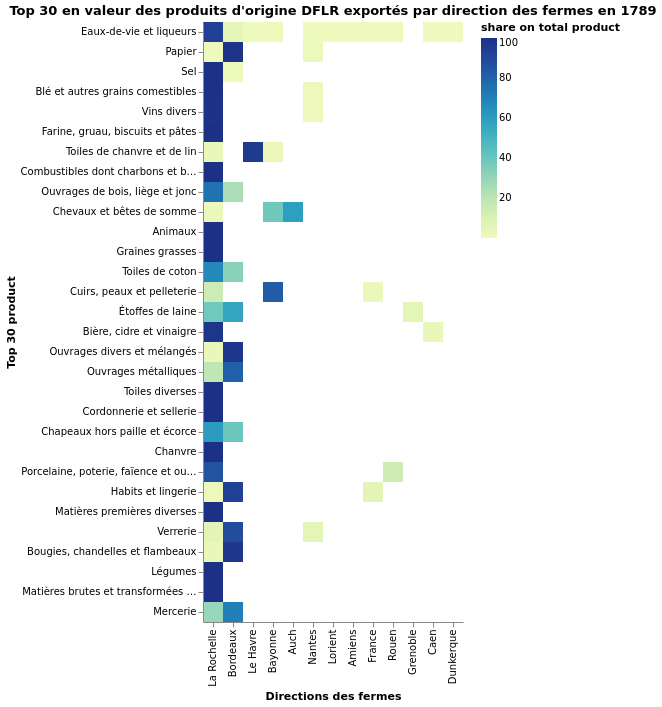

In [84]:
# extract top by value
nb_top_value = 30
top_products = [k for k,v in sorted(total_value_by_product.items(), key=lambda kv:kv[1], reverse=True)[:nb_top_value]]
DFLR_products_region_share = [dict(list(pd.items()) + [("share", 100*pd['value']/total_value_by_product[pd['product']])]) for pd in DFLR_product_direction if pd['product'] in top_products]
VegaLite({
  "title": f"Top {nb_top_value} en valeur des produits d'origine DFLR exportés par direction des fermes en 1789",
  "mark": {"type":"rect", "tooltip": {"content": "data"}},
  "encoding": {
    "x": {
      "field": "region",
      "title": "Directions des fermes",
      "type": "ordinal",
      "sort": {"op":"sum", "field":"value", "order": "descending"}
    },
    "y": {
      "title": f"Top {nb_top_value} product",
      "field":"product",
      "type": "ordinal",
      "sort": {"op":"sum", "field":"value", "order": "descending"}
    },
    "color": {
      "field": "share",
      "title": "share on total product",
      "type": "quantitative",
      #"scale": {"type": "sqrt"}
    }
  },
  "config": {
    "view": {
      "stroke": "transparent"
    }
  }
}, pds.DataFrame(DFLR_products_region_share))

In [81]:
from itertools import groupby
from collections import defaultdict

DFLR_product_region_partner = []

DFLR_origin_flows = (f for f in all_flows if f['origin'] in origins_LaRochelle)
by_region = lambda f: f['customs_region']
by_product = lambda f: f['product_revolutionempire']
for product, flows_by_product in groupby(sorted(DFLR_origin_flows, key = by_product), key = by_product):
    for region, flows_by_region in groupby(sorted(flows_by_product, key = by_region), key = by_region):
        by_partner = lambda f: f['partner_grouping']
        for partner, flows_by_region_by_partner in groupby(sorted(flows_by_region, key=by_partner), key=by_partner):
            flows_by_region_by_partner = list(flows_by_region_by_partner)
            total_value = sum([float(f['value']) for f in flows_by_region_by_partner if f['value'] != ""])
            DFLR_product_region_partner.append({
                "product": product,
                "partner":partner, 
                "region":region,
                "value":total_value})
DFLR_product_region_partner.sort(key = lambda f:f['value'],reverse=True)
print("\n".join((f"{f['region']}->{f['partner']}:{f['value']}" for f in DFLR_product_region_partner[:20])))


La Rochelle->Angleterre:4749261.5005
La Rochelle->France:777984.4198
La Rochelle->Nord:594498.47022
La Rochelle->France:466523.00181999995
La Rochelle->Flandre et autres états de l'Empereur:402640.384
Bordeaux->Nord:379914.0
La Rochelle->France:235915.235
La Rochelle->France:229040.7
Bordeaux->Angleterre:217139.199
Le Havre->Amériques:196699.0
La Rochelle->France:193873.0
La Rochelle->Nord:169070.2464
Bordeaux->Hollande:137295.0
La Rochelle->Nord:119299.0998
La Rochelle->Afrique:118878.0
Bordeaux->Amériques:106063.0
Bordeaux->Nord:89602.599
La Rochelle->France:88124.0
La Rochelle->Hollande:78604.22099999999
La Rochelle->Angleterre:59435.623


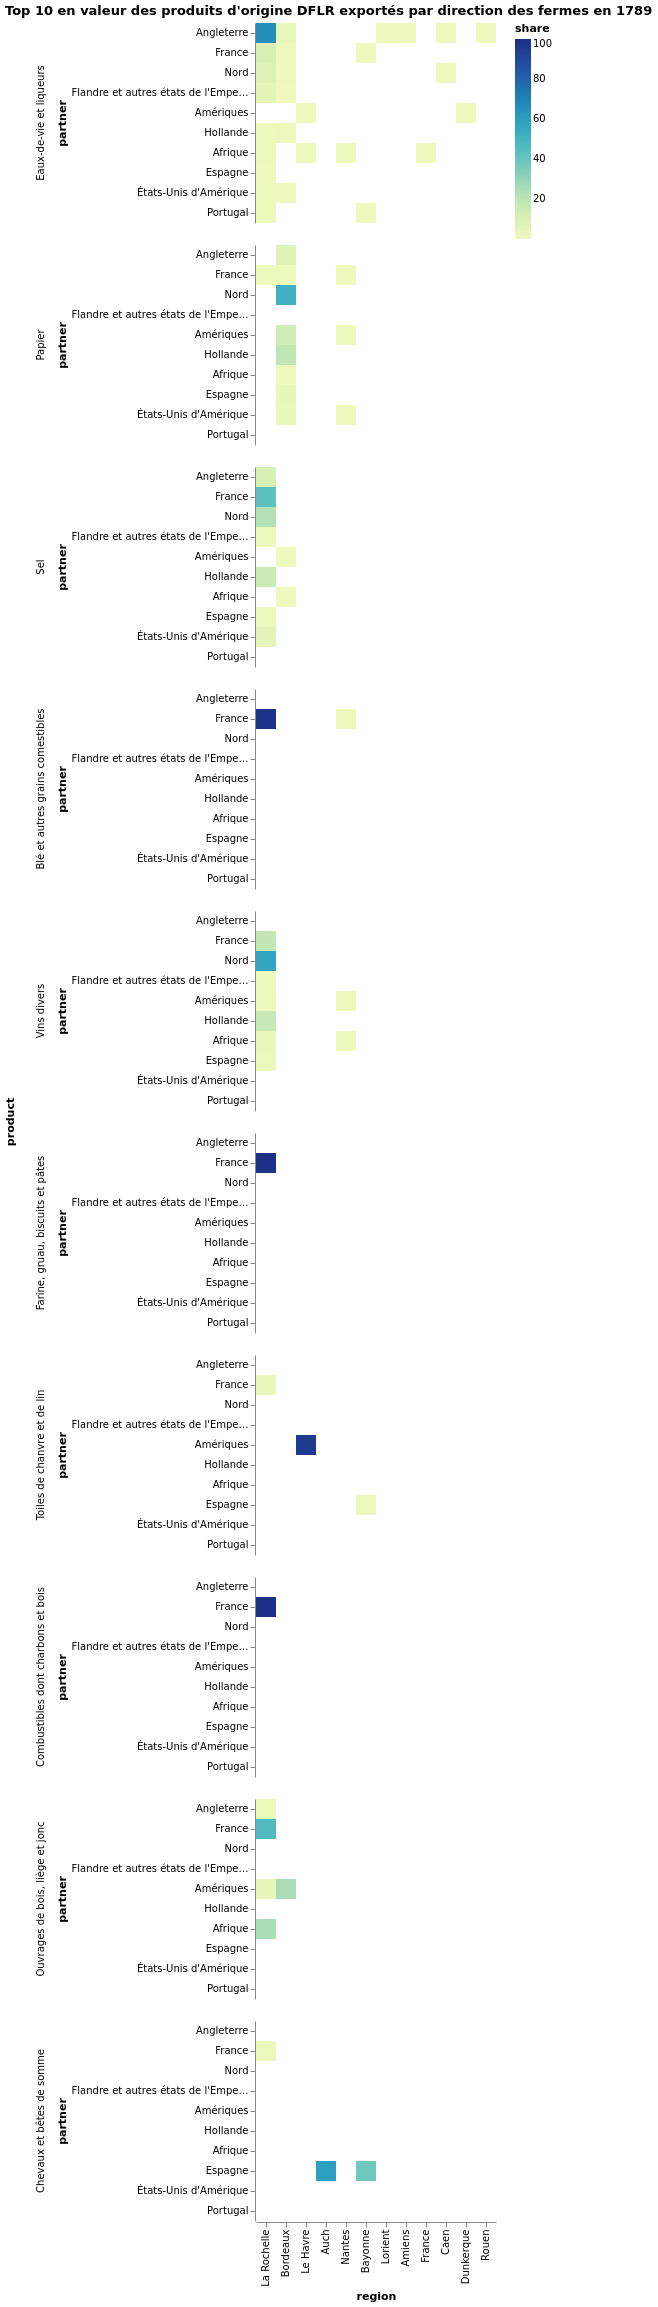

In [85]:
nb_top_value = 10
top_products = [k for k,v in sorted(total_value_by_product.items(), key=lambda kv:kv[1], reverse=True)[:nb_top_value]]
DFLR_products_partner_region_share = [dict(list(pd.items()) + [("share", 100*pd['value']/total_value_by_product[pd['product']])]) for pd in DFLR_product_region_partner if pd['product'] in top_products]

VegaLite({
  "title": f"Top {nb_top_value} en valeur des produits d'origine DFLR exportés par direction des fermes en 1789",
  "mark": {"type":"rect", "tooltip": {"content": "data"}},
  "encoding": {
    "row":{"field":"product", "sort": {"op":"sum", "field":"value", "order": "descending"}},
    "x": {
      "field": "region",
      "label": "Directions des fermes",
      "type": "ordinal",
      "sort": {"op":"sum", "field":"value", "order": "descending"}
    },
    "y": {
      "label": f"Partenaire commercial",
      "field":"partner",
      "type": "ordinal",
      "sort": {"op":"sum", "field":"value", "order": "descending"}
    },
    "color": {
      "field": "share",
      "type": "quantitative",
      #"scale": {"type": "sqrt"}
    }
  },
  "config": {
    "view": {
      "stroke": "transparent"
    }
  }
}, pds.DataFrame(DFLR_products_partner_region_share))

# Matrice province d'origine direction des fermes

In [93]:

from itertools import groupby
from collections import defaultdict

DFLR_product_region_partner = []
total_value_by_province = defaultdict(lambda:0)

by_region = lambda f: f['customs_region']
for region, flows_by_region in groupby(sorted((f for f in all_flows if f['origin']!=''), key = by_region), key = by_region):
    by_province_origin = lambda f: origin_by_province[f['origin']]
    for province, flows_by_province_origin in groupby(sorted(flows_by_region, key=by_province_origin), key=by_province_origin):
            flows_by_province_origin = list(flows_by_province_origin)
            total_value = sum([float(f['value']) for f in flows_by_province_origin if f['value'] != ""])
            total_value_by_province[province]+=total_value
            DFLR_product_region_partner.append({
                "province": province,
                "region":region,
                "value":total_value})
DFLR_product_region_partner.sort(key = lambda f:f['value'],reverse=True)
print("\n".join((f"{f['region']}->{f['province']}:{f['value']}" for f in DFLR_product_region_partner[:20])))

Bordeaux->Guyenne:29592078.048585992
Marseille->Provence:17110802.564870004
Marseille->Languedoc:13201330.75
Besançon->Lyonnais:12354480.216200002
Montpellier->Languedoc:9101973.09293
Bordeaux->:8721299.09015
Marseille->Lyonnais:8463964.16003
Nantes->:6066708.63237
La Rochelle->Angoumois:5989467.99769
Nantes->Bretagne:5874132.010388001
Bordeaux->Bretagne:5252387.9999
Saint-Malo->Bretagne:4851498.227080001
Besançon->Franche-comté:4788778.003509999
Grenoble->Lyonnais:4782207.5504
Marseille->:4081302.3850000002
Bayonne->Navarre-Béarn:4047123.71719
Toulon->Provence:3727329.5712399995
Le Havre->:3067548.0
Flandre->Flandre:2916372.0
Le Havre->Bretagne:2770747.0


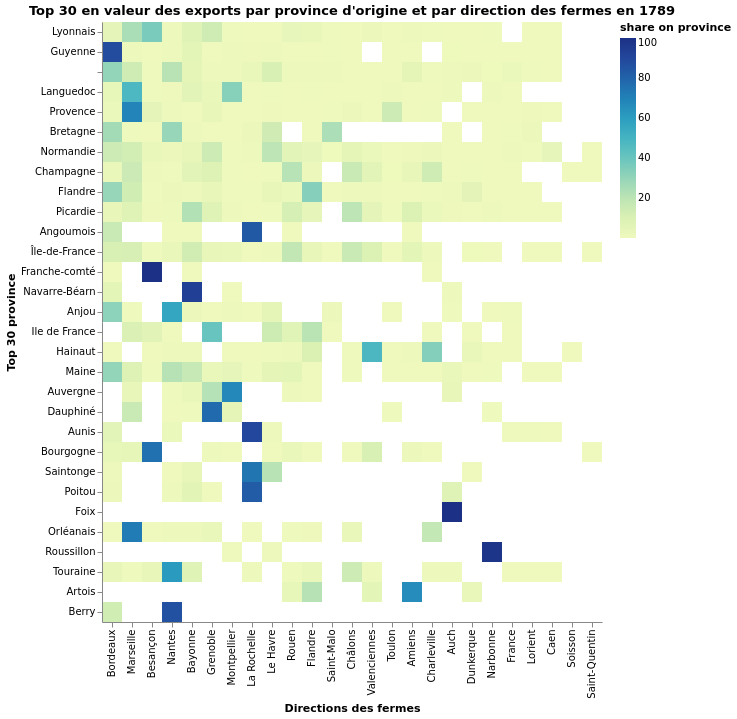

In [99]:
# extract top by value
nb_top_value = 30
top_provinces = [k for k,v in sorted(total_value_by_province.items(), key=lambda kv:kv[1], reverse=True)[:nb_top_value]]
DFLR_product_region_partner_share = [dict(list(pd.items()) + [("share", 100*pd['value']/total_value_by_province[pd['province']])]) for pd in DFLR_product_region_partner if pd['province'] in top_provinces]
VegaLite({
  "title": f"Top {nb_top_value} en valeur des exports par province d'origine et par direction des fermes en 1789",
  "mark": {"type":"rect", "tooltip": {"content": "data"}},
  "encoding": {
    "x": {
      "field": "region",
      "title": "Directions des fermes",
      "type": "ordinal",
      "sort": {"op":"sum", "field":"value", "order": "descending"}
    },
    "y": {
      "title": f"Top {nb_top_value} province",
      "field":"province",
      "type": "ordinal",
      "sort": {"op":"sum", "field":"value", "order": "descending"}
    },
    "color": {
      "field": "share",
      "title": "share on province",
      "type": "quantitative",
    }
  },
  "config": {
    "view": {
      "stroke": "transparent"
    }
  }
}, pds.DataFrame(DFLR_product_region_partner_share))